In [1]:
import numpy as np
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 10)

In [22]:
googl = yf.download("GOOGL", start="2015-01-01", end="2020-01-01")

/home/jupyter/.cache/pypoetry/virtualenvs/compare-multiple-backtests-2J6ybkfi-py3.10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [28]:
def get_di(data, lookback):
    ma = data.rolling(lookback).mean()
    di = ((data - ma) / ma) * 100
    return di


googl["di_14"] = get_di(googl["Close"], 14)
googl = googl.dropna()
googl.tail()

/var/tmp/ipykernel_1472770/1034783830.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  googl['di_14'] = get_di(googl['Close'], 14)


,Open,High,Low,Close,Adj Close,Volume,di_14
Date,,,,,,,
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,-0.212282
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,0.936678
2019-12-27,68.199997,68.352501,67.650002,67.732002,67.732002,23212000,0.275690
2019-12-30,67.840500,67.849998,66.891998,66.985497,66.985497,19994000,-0.812292
2019-12-31,66.789497,67.032997,66.606499,66.969498,66.969498,19514000,-0.817624


In [29]:
def implement_di_strategy(prices, di):
    buy_price = []
    sell_price = []
    di_signal = []
    signal = 0

    for i in range(len(prices)):
        if (
            di[i - 4] < 0
            and di[i - 3] < 0
            and di[i - 2] < 0
            and di[i - 1] < 0
            and di[i] > 0
        ):
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                di_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                di_signal.append(0)
        elif (
            di[i - 4] > 0
            and di[i - 3] > 0
            and di[i - 2] > 0
            and di[i - 1] > 0
            and di[i] < 0
        ):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                di_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                di_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            di_signal.append(0)

    return buy_price, sell_price, di_signal


buy_price, sell_price, di_signal = implement_di_strategy(googl["Close"], googl["di_14"])

/var/tmp/ipykernel_1472770/1071209814.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if di[i-4] < 0 and di[i-3] < 0 and di[i-2] < 0 and di[i-1] < 0 and di[i] > 0:
/var/tmp/ipykernel_1472770/1071209814.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif di[i-4] > 0 and di[i-3] > 0 and di[i-2] > 0 and di[i-1] > 0 and di[i] < 0:
/var/tmp/ipykernel_1472770/1071209814.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_pr

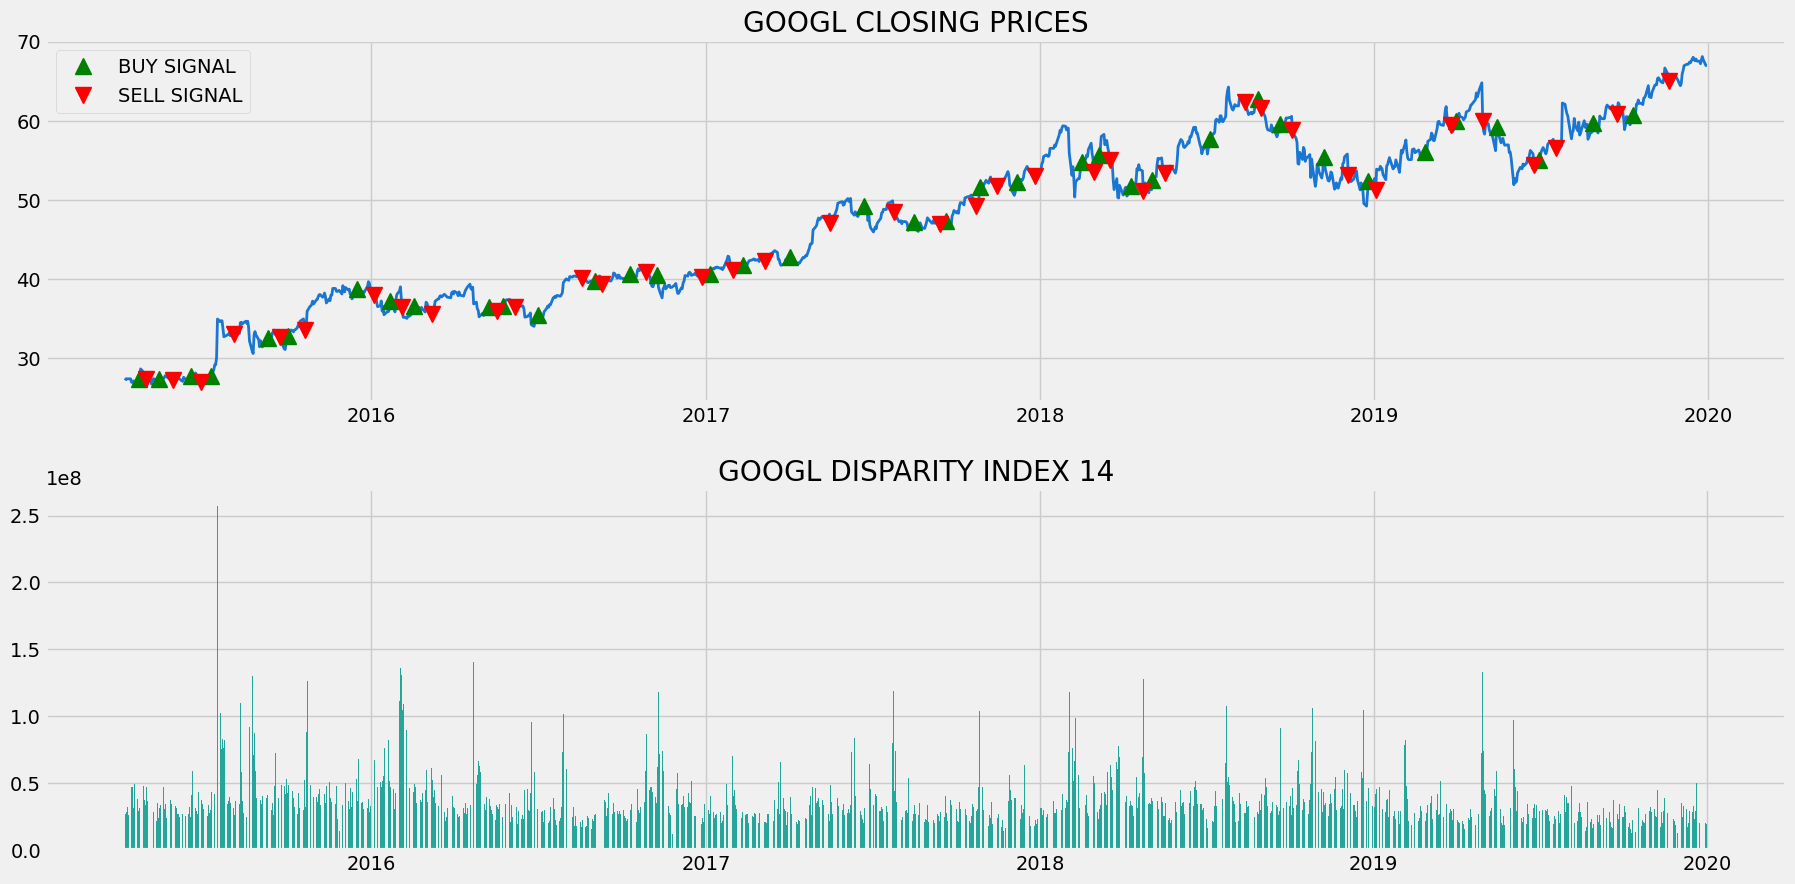

In [30]:
ax1 = plt.subplot2grid((11, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((11, 1), (6, 0), rowspan=5, colspan=1)
ax1.plot(googl["Close"], linewidth=2, color="#1976d2")
ax1.plot(
    googl.index,
    buy_price,
    marker="^",
    markersize=12,
    linewidth=0,
    label="BUY SIGNAL",
    color="green",
)
ax1.plot(
    googl.index,
    sell_price,
    marker="v",
    markersize=12,
    linewidth=0,
    label="SELL SIGNAL",
    color="r",
)
ax1.legend()
ax1.set_title("GOOGL CLOSING PRICES")
for i in range(len(googl)):
    if googl.iloc[i, 5] >= 0:
        ax2.bar(googl.iloc[i].name, googl.iloc[i, 5], color="#26a69a")
    else:
        ax2.bar(googl.iloc[i].name, googl.iloc[i, 5], color="#ef5350")
ax2.set_title("GOOGL DISPARITY INDEX 14")
plt.show()

In [31]:
position = []
for i in range(len(di_signal)):
    if di_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(len(googl["Close"])):
    if di_signal[i] == 1:
        position[i] = 1
    elif di_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i - 1]

close_price = googl["Close"]
di = googl["di_14"]
di_signal = (
    pd.DataFrame(di_signal).rename(columns={0: "di_signal"}).set_index(googl.index)
)
position = (
    pd.DataFrame(position).rename(columns={0: "di_position"}).set_index(googl.index)
)

frames = [close_price, di, di_signal, position]
strategy = pd.concat(frames, join="inner", axis=1)

strategy.head()

,Close,di_14,di_signal,di_position
Date,,,,
2015-04-07,27.243000,-2.471319,0,1
2015-04-08,27.441999,-1.540877,0,1
2015-04-09,27.400999,-1.490432,0,1
2015-04-10,27.427000,-1.188762,0,1
2015-04-13,27.431999,-0.957551,0,1


In [32]:
googl_ret = pd.DataFrame(np.diff(googl["Close"])).rename(columns={0: "returns"})
di_strategy_ret = []

for i in range(len(googl_ret)):
    returns = googl_ret["returns"][i] * strategy["di_position"][i]
    di_strategy_ret.append(returns)

di_strategy_ret_df = pd.DataFrame(di_strategy_ret).rename(columns={0: "di_returns"})
investment_value = 100000
number_of_stocks = floor(investment_value / googl["Close"][0])
di_investment_ret = []

for i in range(len(di_strategy_ret_df["di_returns"])):
    returns = number_of_stocks * di_strategy_ret_df["di_returns"][i]
    di_investment_ret.append(returns)

di_investment_ret_df = pd.DataFrame(di_investment_ret).rename(
    columns={0: "investment_returns"}
)
total_investment_ret = round(sum(di_investment_ret_df["investment_returns"]), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)
print(
    cl(
        "Profit gained from the DI strategy by investing $100k in GOOGL : {}".format(
            total_investment_ret
        ),
        attrs=["bold"],
    )
)
print(
    cl(
        "Profit percentage of the DI strategy : {}%".format(profit_percentage),
        attrs=["bold"],
    )
)

Profit gained from the DI strategy by investing $100k in GOOGL : 60953.21
Profit percentage of the DI strategy : 60%


/var/tmp/ipykernel_1472770/3460933419.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns = googl_ret['returns'][i]*strategy['di_position'][i]
/var/tmp/ipykernel_1472770/3460933419.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  number_of_stocks = floor(investment_value/googl['Close'][0])
